In [9]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from scalable_gps import kernels
from scalable_gps import thompson_sampling

seed = 0
D = 1

kernel_name = "Matern32Kernel"
signal_scale = 1.0
length_scale = jnp.array([0.1])
noise_scale = 1e-3

kernel_init_fn = getattr(kernels, kernel_name)
kernel = kernel_init_fn({'signal_scale': signal_scale, 'length_scale': length_scale})

n_features = 1000
n_data_init = 10
n_friends = 5
n_samples = 2

feature_fn, objective_fn, ds_init = thompson_sampling.init(seed, D, kernel, n_features=n_features, n_data_init=n_data_init)
L_init = feature_fn(ds_init.x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
### Random Search
key = jax.random.PRNGKey(12345)
x_batch_random = jax.random.uniform(key, shape=(n_samples, D), minval=-1, maxval=1)
ds_random = thompson_sampling.add_batch(ds_init, x_batch_random, objective_fn)

In [10]:
### ExactGP
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.data import Dataset

exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)
alpha_map = exact_gp.compute_representer_weights(ds_init)

friends_key = jax.random.PRNGKey(42)
x_friends = thompson_sampling.find_friends(friends_key, ds_init, n_friends)
ds_friends = Dataset(x_friends, None, n_friends, D)
L = jnp.concatenate([L_init, feature_fn(x_friends)], axis=0)
print(L.shape)

samples_key = jax.random.PRNGKey(1337)
y_pred_friends, alpha_samples, w_samples = exact_gp.compute_posterior_samples(samples_key, n_samples, ds_init, ds_friends, use_rff=True, L=L, zero_mean=False)


(15, 1000)
(2, 10) (2, 5) (2, 10) (2, 1000)


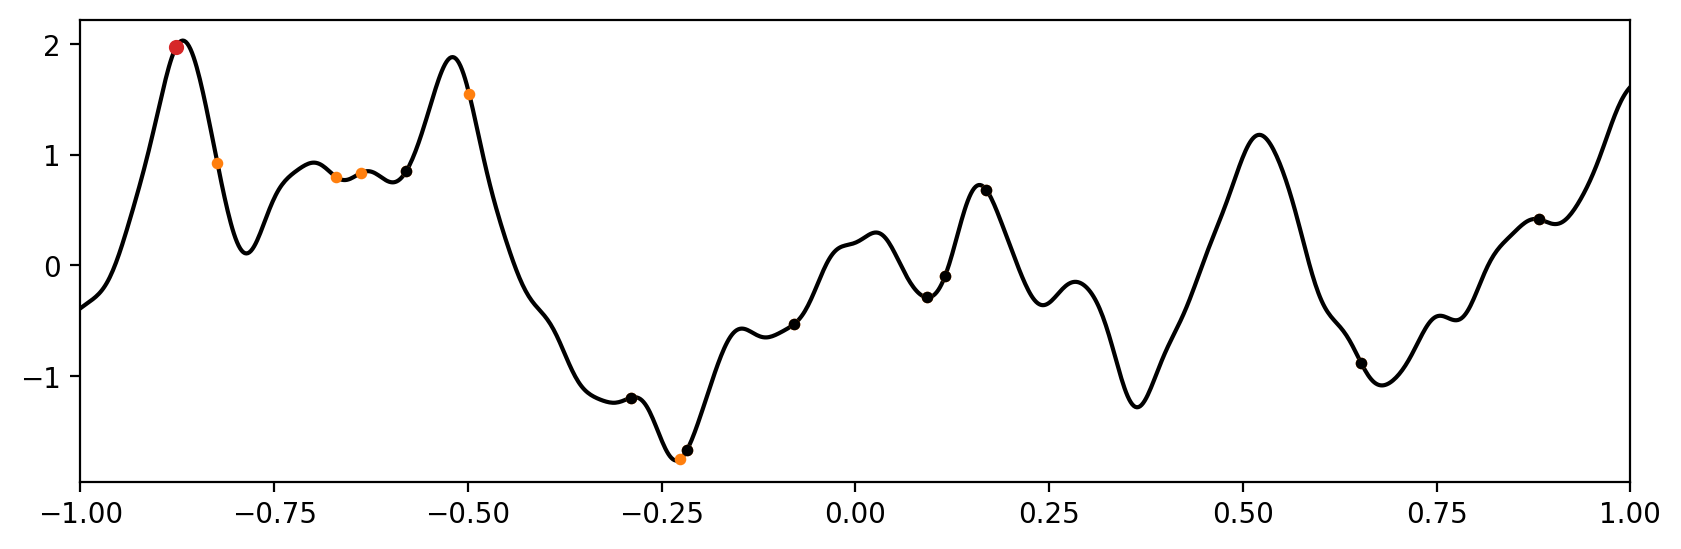

In [34]:
import matplotlib.pyplot as plt

ds = ds_random

n_plot = 1000
x_plot = jnp.linspace(-1, 1, num=n_plot)[:, None]

fig = plt.figure(dpi=200, figsize=[10, 3])
ax = fig.add_subplot(111)
ax.set_xlim(-1, 1)
ax.plot(x_plot, f(x_plot), color='k')
ax.scatter(ds_init.x, ds_init.y, color='k', marker='o', s=10, zorder=3)
ax.scatter(ds.x, ds.y, color='tab:orange', marker='o', s=10, zorder=2)
ax.scatter(*thompson_sampling.get_maximum(ds), color='tab:red', marker='o', s=20, zorder=3)
# ax.scatter(x_init, f_init, color='tab:blue', marker='o', s=10)
# ax.plot(x_plot, posterior_samples.T, color='tab:blue', linestyle='--', linewidth=0.7)
# ax.plot(x_friend, y_friend, color='tab:orange', marker='*', s=10)